In [8]:
!pip install pyalgotrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyalgotrade: filename=PyAlgoTrade-0.20-py3-none-any.whl size=159512 sha256=6e04a546bc1f02aaa3315e4ba3b1983041e6c84080123da86b45f3f4488d7b57
  Stored in directory: /root/.cache/pip/wheels/72/46/5c/ec695f4cbbdfbf40269fa8a4096c418670af83ed9aa40d669f
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=459cf69a454e380eaee8b989ce2c94c7ed1f43224d6bd3bbcf8ece4995364dcf
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built pyalgotrade ws4py


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import  pandas as pd

In [3]:
path = "/content/drive/MyDrive/trader/data_2020_2023_5min.csv"
df = pd.read_csv(path)

In [4]:
df['datetime'] = pd.to_datetime(df['datetime']).dt.strftime('%Y-%m-%dT%H:%M:%S.000Z')

In [5]:
df1 = df.rename(columns={
    'datetime': 'Date Time',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

In [6]:
df1.head()

,Date Time,Open,High,Low,Close,Volume
0,2020-01-01T05:30:00.000Z,7195.24,7196.25,7178.64,7179.78,95.509133
1,2020-01-01T05:35:00.000Z,7179.76,7191.77,7178.20,7191.07,59.365225
2,2020-01-01T05:40:00.000Z,7193.15,7193.53,7180.24,7180.97,48.068510
3,2020-01-01T05:45:00.000Z,7180.97,7186.40,7177.35,7178.29,32.192929
4,2020-01-01T05:50:00.000Z,7177.71,7182.46,7175.47,7176.96,49.027397


In [7]:
df1.to_csv('data.csv', index=False)

Adaptive  Moving Average:
Analogy:
Think of AMA as a car’s cruise control system on a road trip:

**Simple Moving Average (SMA)** is like a constant-speed setting, where the car always tries to maintain the same speed (average of past prices) regardless of the road conditions.

**Exponential Moving Average (EMA)** is like a cruise control system that adjusts the speed based on more recent road conditions (recent prices), but it still doesn’t fully adapt to changing conditions.

**Adaptive Moving Average (AMA)**, on the other hand, is like a smart cruise control system that dynamically adjusts the car's speed based on both the distance to your destination (price trend) and the road's bumpiness (volatility). On smooth, straight roads (steady trends), it accelerates and maintains higher speeds (responds faster to price trends). On winding, bumpy roads (volatile markets), it slows down and becomes more cautious (smooths out erratic price changes).
In the context of your trading strategy:

When the price is moving steadily in one direction, AMA adjusts quickly, allowing the strategy to capture trends.
When the price is volatile, AMA becomes less responsive, filtering out noise and reducing false signals.
Theory Behind AMA:
The Adaptive Moving Average (AMA) is a technical indicator developed by Perry Kaufman that combines trend-following with noise filtering. It adapts to price volatility, adjusting its smoothing factor based on market conditions.

**Efficiency Ratio (ER):**

The formula

ER
=
Price Change
Volatility
ER=
Volatility
Price Change
​
  measures the market's trending efficiency. ER ranges from 0 (random/noisy market) to 1 (strong trend).
If the price moves steadily, the ER is closer to 1, meaning that the market is trending. If the price fluctuates randomly, ER is closer to 0.
Smoothing Constant (SC):

The smoothing constant is derived from ER and dynamically adjusts the weight given to the latest price change:

SC
=
𝐸
𝑅
×
(
SC
fast
−
SC
slow
)
+
SC
slow
SC=ER×(SC
fast
​
 −SC
slow
​
 )+SC
slow
​

This allows AMA to behave like a fast-moving average when ER is high (strong trend) and like a slow-moving average when ER is low (volatile market).
AMA Calculation:

AMA is recursively calculated using:
AMA
new
=
AMA
old
+
𝑆
𝐶
×
(
Price
new
−
AMA
old
)
AMA
new
​
 =AMA
old
​
 +SC×(Price
new
​
 −AMA
old
​
 )
AMA moves closer to the price when the trend is strong (faster adaptation) and stays relatively flat when the market is noisy (slower adaptation).
Strategy Application:
Buy Signal: When the price crosses above the AMA, it indicates a potential upward trend, so a long position is entered.
Sell Signal: When the price crosses below the AMA, it signals a potential downward trend, so the position is exited.

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter
import datetime

class AdaptiveMovingAverage:
    def __init__(self, period, fast_ema_period=2, slow_ema_period=30):
        self.period = period
        self.fast_ema_period = fast_ema_period
        self.slow_ema_period = slow_ema_period
        self.prices = []
        self.ama_values = []

    def add_price(self, price):
        self.prices.append(price)
        if len(self.prices) > self.period:
            self.prices.pop(0)

        if len(self.prices) >= self.period:
            self.calculate_ama()

    def calculate_ama(self):
        price_change = abs(self.prices[-1] - self.prices[0])
        volatility = sum([abs(self.prices[i] - self.prices[i-1]) for i in range(1, len(self.prices))])
        er = price_change / volatility if volatility != 0 else 0
        sc_fast = 2 / (self.fast_ema_period + 1)
        sc_slow = 2 / (self.slow_ema_period + 1)
        sc = er * (sc_fast - sc_slow) + sc_slow
        sc = sc ** 2

        if len(self.ama_values) == 0:
            self.ama_values.append(self.prices[-1])  # Start AMA with the first price
        else:
            ama_value = self.ama_values[-1] + sc * (self.prices[-1] - self.ama_values[-1])
            self.ama_values.append(ama_value)

    def get_latest_ama(self):
        if len(self.ama_values) > 0:
            return self.ama_values[-1]
        return None

class AMAStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, ama_period, fast_ema_period, slow_ema_period):
        super(AMAStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__ama = AdaptiveMovingAverage(ama_period, fast_ema_period, slow_ema_period)
        self.__position = None

    def onBars(self, bars):
        bar = bars[self.__instrument]
        price = bar.getClose()
        self.__ama.add_price(price)

        ama_value = self.__ama.get_latest_ama()

        if ama_value is None:
            return
        if self.__position is None and price > ama_value:
            self.__position = self.enterLong(self.__instrument, 1, True)
            # self.info(f"Buy signal at {bar.getDateTime()}, price: {price}, AMA: {ama_value}")
        elif self.__position is not None and price < ama_value:
            self.__position.exitMarket()
            # self.info(f"Sell signal at {bar.getDateTime()}, price: {price}, AMA: {ama_value}")
            self.__position = None


INFO:strategy:Final portfolio value: $1149134.9001069877
2024-10-12 12:56:20,934 strategy [INFO] Final portfolio value: $1149134.9001069877


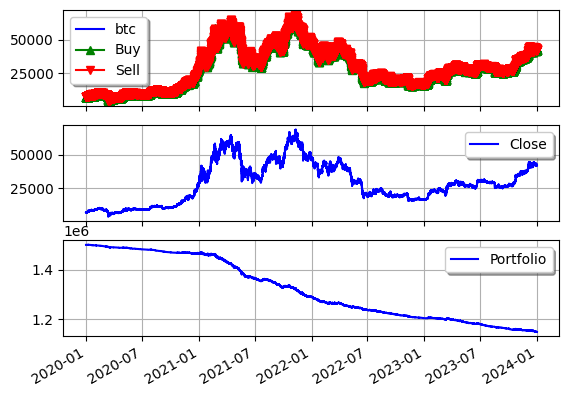

In [ ]:

def run_strategy(ama_period, fast_ema_period, slow_ema_period):
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")

    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = AMAStrategy(feed, "btc", broker, ama_period, fast_ema_period, slow_ema_period)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())

    # Run the strategy and show the final portfolio value
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()

run_strategy(ama_period=10, fast_ema_period=2, slow_ema_period=30)


**Donchian Channel**

**Analogy:**
Imagine you're watching the performance of a team over a season. The team's best (highest) and worst (lowest) performances over a specific number of games define the Donchian Channel. This gives you an upper limit (high performance) and a lower limit (low performance) within which the team typically operates. When the team's current performance exceeds the previous best, you might expect further improvement, so you bet on (enter a long position) the team. However, if the team's current performance drops below the previous worst, you exit the bet (sell).

In trading terms:

The upper band of the Donchian Channel represents the highest price (team's best performance) over a given period (e.g., 20 days).
The lower band represents the lowest price (team's worst performance) over the same period.
When the price exceeds the upper band, it's a breakout signal, suggesting a strong upward momentum.
When the price falls below the lower band, it's a sign of downward momentum, and you exit your position.
Theory Behind Donchian Channels:
The Donchian Channel is a volatility-based indicator developed by Richard Donchian, and it helps traders identify breakouts in price movement. It consists of:

**Upper Band:** The highest high over a specific period.

**Lower Band:** The lowest low over the same period.

**Middle Line (optional)**: The average of the upper and lower bands.

Key Concepts:

**Breakouts:** The Donchian Channel is based on the idea that a breakout beyond recent price ranges can signal the start of a new trend. Traders use breakouts above the upper band to enter long positions and breakouts below the lower band to exit or enter short positions.
**Trend-Following System:** The Donchian Channel helps capture trends by defining clear boundaries. If the price breaks above the upper band, it's a signal that an uptrend might be starting. Conversely, if the price drops below the lower band, it indicates a possible downtrend.
How It Works:

**Upper Band:** It is the maximum of the high prices over the chosen period. In your code, when you add a new price (high), if the number of highs exceeds the period, the oldest price is removed.

**Lower Band:** It is the minimum of the low prices over the chosen period. Similarly, lows beyond the period are removed.
The bands dynamically adjust to reflect new highs and lows over time.
Strategy Application:
In your DonchianStrategy:

**Buy Condition (Enter Long):**

If the closing price breaks above the upper band of the Donchian Channel, it indicates upward momentum. This triggers the strategy to enter a long position.

**Sell Condition (Exit):**

If the closing price falls below the lower band, it indicates a downward breakout. This triggers an exit from the position (sell).

In [ ]:

class DonchianChannel:
    def __init__(self, period):
        self.period = period
        self.highs = []
        self.lows = []
        self.upper_band = None
        self.lower_band = None

    def add_price(self, high, low):
        self.highs.append(high)
        self.lows.append(low)

        if len(self.highs) > self.period:
            self.highs.pop(0)
        if len(self.lows) > self.period:
            self.lows.pop(0)

        if len(self.highs) == self.period:
            self.upper_band = max(self.highs)
            self.lower_band = min(self.lows)

    def get_upper_band(self):
        return self.upper_band

    def get_lower_band(self):
        return self.lower_band

class DonchianStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, dc_period):
        super(DonchianStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__donchian_channel = DonchianChannel(dc_period)
        self.__position = None

    def onBars(self, bars):
        bar = bars[self.__instrument]
        high = bar.getHigh()
        low = bar.getLow()
        close = bar.getClose()
        self.__donchian_channel.add_price(high, low)

        upper_band = self.__donchian_channel.get_upper_band()
        lower_band = self.__donchian_channel.get_lower_band()
        if upper_band is None or lower_band is None:
            return
        if self.__position is None and close > upper_band:
            self.__position = self.enterLong(self.__instrument, 1, True)
        elif self.__position is not None and close < lower_band:
            self.__position.exitMarket()
            self.__position = None




INFO:strategy:Final portfolio value: $1500000
2024-10-12 13:00:04,102 strategy [INFO] Final portfolio value: $1500000


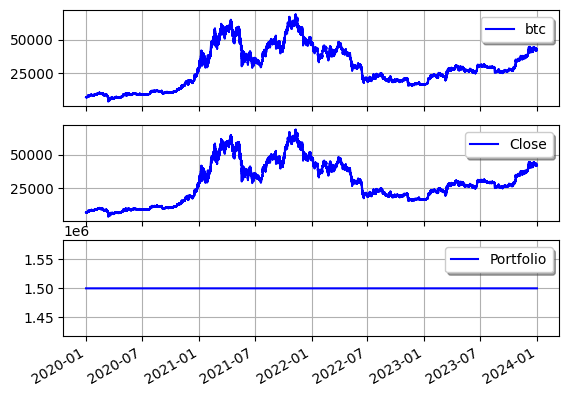

In [ ]:
def run_strategy(dc_period):
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = DonchianStrategy(feed, "btc", broker, dc_period)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()

run_strategy(dc_period=5)

**Keltner Channels**



# Keltner Channels Strategy: Analogy and Theory

The **Keltner Channels Strategy**  can be compared to driving within designated lanes on a highway, where these lanes expand or contract depending on traffic conditions (volatility). Here's a detailed analogy:

### Analogy:

Think of the **Keltner Channels** as the **lanes** of a highway:
- The **middle lane** is like the **Exponential Moving Average (EMA)**, which represents the “smooth flow” of traffic based on recent price data.
- The **upper and lower lanes** (or boundaries) represent a dynamic range, defined by the price's volatility (via the **Average True Range (ATR)**), just like how lanes expand during peak traffic (high volatility) and contract when the road is clear (low volatility).

In this analogy:
- When your car (price) drifts too far from the middle lane (EMA) and crosses into the upper or lower lanes, it’s as if you’re moving into extreme conditions.
  - If your car breaks out to the **upper lane**, it’s like going faster than normal, signaling an upward trend, and the strategy may trigger a **long (buy) position**.
  - If your car veers into the **lower lane**, it’s like slowing down significantly, signaling a downward trend, and the strategy may trigger a **short (sell) position**.
  
Additionally, the **stop loss** and **take profit** mechanisms act like **speed limits** on this highway:
- If you’ve gone **too fast** or **too slow** (beyond your target), the system will pull you back by closing your position.
- If you’re driving within the limits (the price remains within a reasonable range), the position remains open.

### Theory Behind Keltner Channels:

The **Keltner Channels** indicator consists of three key components:
1. **Middle Line (EMA):** This is a smooth moving average (typically an Exponential Moving Average) that represents the general trend or direction of the price.
2. **Upper Band:** Calculated as the EMA plus a multiple of the **ATR (Average True Range)**, which accounts for volatility. This creates an upper boundary above the price.
3. **Lower Band:** Calculated as the EMA minus a multiple of the ATR, forming a lower boundary.

- The **ATR multiplier** is used to widen or narrow the upper and lower bands based on the volatility of the market. When volatility increases, the bands expand, and when volatility decreases, the bands contract.
- The **ATR** measures the range of price movement, representing how volatile the price is over a given period.

### Strategy Application:

1. **Buy Condition (Enter Long):**
   - When the current price breaks above the **upper band** of the Keltner Channel, it signals that the price is in a strong upward trend. The strategy opens a **long position** (buy) to take advantage of the bullish momentum.

2. **Sell Condition (Enter Short):**
   - If the current price breaks below the **lower band**, it indicates that the price is in a strong downward trend. The strategy opens a **short position** to profit from the bearish movement.

3. **Exiting the Position:**
   - **Take Profit:** If the price moves significantly in the profitable direction (above a specified threshold for long, below for short), the position is closed to lock in gains.
   - **Stop Loss:** If the price moves against the position (below a threshold for long, above for short), the position is closed to minimize losses.

### Summary:
- The **Keltner Channels** act as dynamic lanes (upper and lower bands) based on price volatility.
- The strategy trades based on price breakouts, either above or below these lanes.
- The **EMA** is the central lane, and the **ATR** defines how wide or narrow the upper and lower lanes should be, adjusting to the market’s volatility.
- The **take profit** and **stop loss** act as safeguards, ensuring positions are closed when certain thresholds are reached, either for profit or to avoid excessive losses.


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.technical import atr

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.technical import atr
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter

class KeltnerChannelsStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, period, atr_multiplier, take_profit, stop_loss):
        super().__init__(feed, broker)
        self.instrument = instrument
        self.price_data_series = feed[instrument].getPriceDataSeries()
        self.ma = ma.EMA(self.price_data_series, period)
        self.atr = atr.ATR(feed[instrument], period)  # Ensure we're using the correct data for ATR

        self.atr_multiplier = atr_multiplier
        self.take_profit = take_profit
        self.stop_loss = stop_loss

        self.position = None
        self.upper_band = None
        self.lower_band = None

    def onBars(self, bars):
        if self.ma[-1] is None or self.atr[-1] is None:
            return

        current_price = bars[self.instrument].getPrice()
        self.upper_band = self.ma[-1] + (self.atr[-1] * self.atr_multiplier)
        self.lower_band = self.ma[-1] - (self.atr[-1] * self.atr_multiplier)

        if self.position is None:
            if current_price > self.upper_band:
                self.position = self.enterLong(self.instrument, 1, True)
            elif current_price < self.lower_band:
                self.position = self.enterShort(self.instrument, 1, True)
        else:
            entry_price = self.position.getEntryOrder().getExecutionInfo().getPrice()
            if self.position.getShares() > 0:
                if current_price >= entry_price * (1 + self.take_profit) or \
                   current_price <= entry_price * (1 - self.stop_loss):
                    self.position.exitMarket()
                    self.position = None
            elif self.position.getShares() < 0:
                if current_price <= entry_price * (1 - self.take_profit) or \
                   current_price >= entry_price * (1 + self.stop_loss):
                    self.position.exitMarket()
                    self.position = None


Final portfolio value: $1369616.24


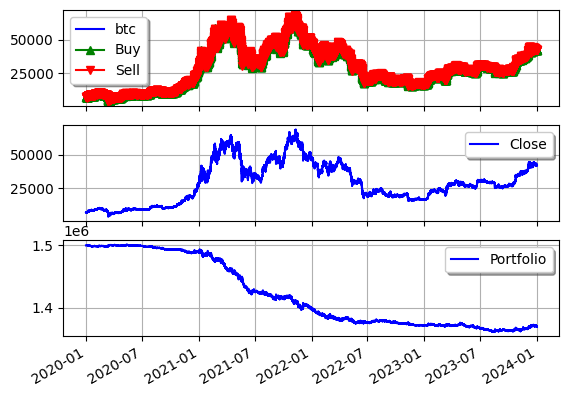

In [ ]:
def run_keltner_strategy(period, atr_multiplier, take_profit, stop_loss):
    feed = csvfeed.GenericBarFeed(frequency=60 * 5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")

    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)

    strategy = KeltnerChannelsStrategy(feed, "btc", broker, period, atr_multiplier, take_profit, stop_loss)
    plotter_instance = plotter.StrategyPlotter(strategy)
    plotter_instance.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())

    strategy.run()
    print(f'Final portfolio value: ${strategy.getResult():.2f}')  # Print final portfolio value
    plotter_instance.plot()
run_keltner_strategy(20, 1.5, 0.018, 0.003)

Stochastic Oscillator
The **Stochastic Oscillator Strategy** can be compared to driving on a winding road and using a **GPS** to track your speed in relation to the road's speed limits.

### Analogy:

- **The Road’s Curves (Highs and Lows):** The highs and lows of the market are like the curvy sections of a road, with steep hills and valleys. These represent the price extremes within a period, which help determine whether you are approaching dangerous territory (overbought or oversold conditions).
  
- **The GPS Speedometer (%K Line):** The **%K line** represents your **current speed** on the road. It shows how fast you're moving relative to the recent terrain (price changes). A high %K value means you’re speeding up toward the upper limit of what’s safe, while a low %K value indicates you're slowing down near the lower limit.

- **The Speed Limit Sign (%D Line):** The **%D line** is like the **posted speed limit** on the road. It's an average of recent speeds (%K values) and provides a guide for how fast you should be moving through the current conditions.

- **Decision to Speed Up or Slow Down (Buy/Sell Signals):**
  - When your current speed (%K) **exceeds the speed limit (%D)**, it’s a signal to **accelerate (buy)**, as it indicates bullish momentum.
  - When your speed (%K) **drops below the speed limit (%D)**, it's a sign to **slow down (sell)**, as momentum may be reversing.

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter

class StochasticOscillator:
    def __init__(self, period, smoothK=3, smoothD=3):
        self.period = period
        self.smoothK = smoothK
        self.smoothD = smoothD
        self.highs = []
        self.lows = []
        self.closes = []
        self.k_values = []
        self.d_values = []

    def add_price(self, high, low, close):
        self.highs.append(high)
        self.lows.append(low)
        self.closes.append(close)
        if len(self.highs) > self.period:
            self.highs.pop(0)
        if len(self.lows) > self.period:
            self.lows.pop(0)
        if len(self.closes) > self.period:
            self.closes.pop(0)

        if len(self.highs) == self.period:
            self.calculate_stochastic()

    def calculate_stochastic(self):
        highest_high = max(self.highs)
        lowest_low = min(self.lows)
        last_close = self.closes[-1]

        if highest_high - lowest_low != 0:
            k = (last_close - lowest_low) / (highest_high - lowest_low) * 100
        else:
            k = 0

        self.k_values.append(k)


        if len(self.k_values) > self.smoothK:
            self.k_values.pop(0)

        if len(self.k_values) >= self.smoothK:
            smoothed_k = sum(self.k_values) / len(self.k_values)
            self.d_values.append(smoothed_k)
        if len(self.d_values) > self.smoothD:
            self.d_values.pop(0)

    def get_latest_k(self):
        if self.k_values:
            return self.k_values[-1]
        return None

    def get_latest_d(self):
        if self.d_values:
            return self.d_values[-1]
        return None

class StochasticStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, period, smoothK=3, smoothD=3):
        super(StochasticStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__stochastic = StochasticOscillator(period, smoothK, smoothD)
        self.__position = None

    def onBars(self, bars):
        bar = bars[self.__instrument]
        high = bar.getHigh()
        low = bar.getLow()
        close = bar.getClose()
        self.__stochastic.add_price(high, low, close)

        k_value = self.__stochastic.get_latest_k()
        d_value = self.__stochastic.get_latest_d()
        if k_value is None or d_value is None:
            return
        if self.__position is None and k_value > d_value:
            self.__position = self.enterLong(self.__instrument, 1, True)
        elif self.__position is not None and k_value < d_value:
            self.__position.exitMarket()
            self.__position = None

DEBUG:broker.backtesting:Not enough volume to fill btc market order [6069] for 1 share/s
2020-02-19 17:05:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [6069] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [47966] for 1 share/s
2021-02-11 07:50:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [47966] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [47966] for 1 share/s
2021-02-11 07:55:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [47966] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [47966] for 1 share/s
2021-02-11 08:00:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [47966] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [47966] for 1 share/s
2021-02-11 08:05:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [47966] for 1 

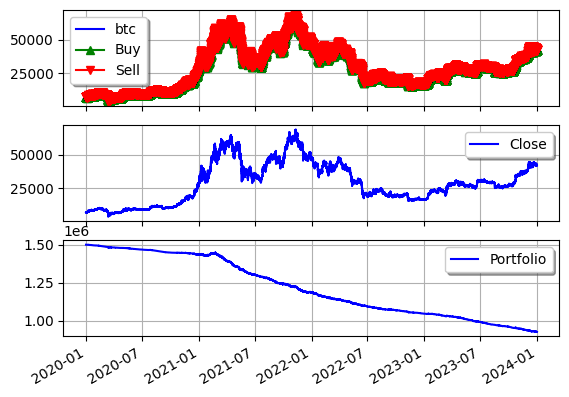

In [ ]:
def run_strategy(period):
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = StochasticStrategy(feed, "btc", broker, period)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()
run_strategy(period=14)

**MA Trend Following:**

The **Moving Average Trend Following Strategy** can be compared to steering a boat across the sea, using two different compasses—one for short-term trends (short moving average) and another for long-term trends (long moving average).

### Analogy:

- **The Boat (Your Position):** The boat represents your position in the market, whether you are currently invested (in a long position) or not.

- **The Short-Term Compass (Short Moving Average):** The short moving average is like a compass that tracks the **recent direction of the waves**. It gives you quick feedback on how the sea is moving in the short term. If the waves start moving upward, it signals that you're moving toward better waters (indicating a buy signal).

- **The Long-Term Compass (Long Moving Average):** The long moving average is like a compass that tracks the **overall direction of the sea** over a longer period. It gives you a sense of the bigger picture. Even if there are short-term shifts in direction, this compass helps you stay on the long-term course.

- **Decision to Set Sail (Buy) or Anchor (Sell):**
  - When the **short-term compass points upward**, indicating that the sea is moving toward better conditions, and it crosses the direction of the long-term compass, you decide to **set sail (buy)**. This is like catching a favorable wave.
  - When the **short-term compass dips below the long-term compass**, suggesting the sea is moving away from favorable conditions, you **drop anchor (sell)** and wait for better conditions to return.

In this way, just as a captain navigates a boat by balancing short-term and long-term changes in the sea's direction, the moving average strategy navigates the market by balancing short-term price trends against long-term trends.

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter

class MovingAverage:
    def __init__(self, period):
        self.period = period
        self.prices = []
        self.sma_value = None

    def add_price(self, price):
        self.prices.append(price)
        if len(self.prices) > self.period:
            self.prices.pop(0)

        if len(self.prices) == self.period:
            self.sma_value = sum(self.prices) / self.period

    def get_latest_sma(self):
        return self.sma_value

class TrendFollowingStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, short_window, long_window):
        super(TrendFollowingStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__short_ma = MovingAverage(short_window)
        self.__long_ma = MovingAverage(long_window)
        self.__position = None

    def onBars(self, bars):
        bar = bars[self.__instrument]
        close = bar.getClose()
        self.__short_ma.add_price(close)
        self.__long_ma.add_price(close)

        short_sma = self.__short_ma.get_latest_sma()
        long_sma = self.__long_ma.get_latest_sma()
        if short_sma is None or long_sma is None:
            return
        if self.__position is None and short_sma > long_sma:
            self.__position = self.enterLong(self.__instrument, 1, True)

        elif self.__position is not None and short_sma < long_sma:
            self.__position.exitMarket()
            self.__position = None

DEBUG:broker.backtesting:Not enough volume to fill btc market order [4913] for 1 share/s
2021-02-11 07:55:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [4913] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [4913] for 1 share/s
2021-02-11 08:00:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [4913] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [4913] for 1 share/s
2021-02-11 08:05:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [4913] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [4913] for 1 share/s
2021-02-11 08:10:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [4913] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [4913] for 1 share/s
2021-02-11 08:15:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [4913] for 1 share/s


Final portfolio value: $1451746.53


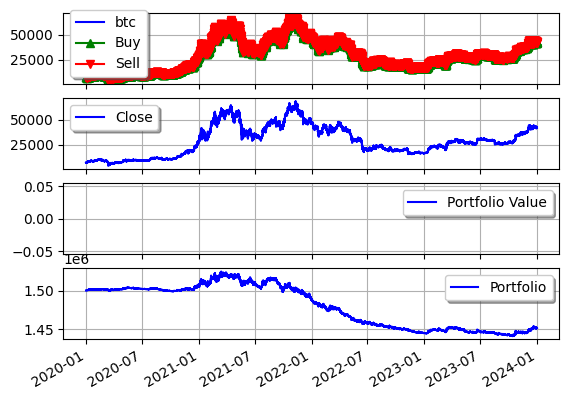

In [ ]:
def run_strategy(short_window, long_window):
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = TrendFollowingStrategy(feed, "btc", broker, short_window, long_window)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    equity_series = []
    myStrategy.run()
    for bar in feed:
        equity_series.append(broker.getEquity())
    final_value = myStrategy.getResult()
    print(f'Final portfolio value: ${final_value:.2f}')
    plt.getOrCreateSubplot("Portfolio Value").addDataSeries("Portfolio Value", equity_series)
    plt.plot()


run_strategy(short_window=10, long_window=30)

The **VWAP (Volume Weighted Average Price) Strategy** can be compared to measuring the performance of a team in a relay race, where each runner’s speed is weighted by how much of the race they ran, similar to how price is weighted by volume in VWAP.

### Analogy:

- **The Race (Market Activity):** Imagine a relay race where several runners (trades) are passing the baton (price changes). Each runner represents a trade, and the **speed** of the runner represents the **price** at which that trade occurred.

- **Distance Covered (Volume):** Each runner covers a certain distance based on their contribution to the race. The more distance a runner covers, the more influence they have on the overall race result. Similarly, in the VWAP calculation, the **volume** of each trade affects the influence of that trade on the overall VWAP value.

- **The Team’s Average Speed (VWAP):** The VWAP is like calculating the **team’s average speed** for the whole race, where each runner’s speed is weighted by how far they ran. A runner who covered a longer distance has a bigger impact on the final average speed of the team. In VWAP, the price of each trade is weighted by the volume of that trade to calculate an average price.

- **Decision to Sprint (Buy) or Slow Down (Sell):**
  - When the **current price is above the team's average speed (VWAP)**, it’s like realizing you’re running faster than the team’s average pace. This can be a signal to **sprint ahead (buy)** and take advantage of the market momentum.
  - When the **current price falls below the team’s average speed**, it’s like realizing you’re falling behind the team’s pace. This can signal that it's time to **slow down or stop (sell)**, as the market momentum may be fading.

In this analogy, just as you assess your position in the race compared to your team’s average speed, in the VWAP strategy, you assess the stock's price relative to the VWAP to make buy and sell decisions based on market momentum.

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter

class VWAP:
    def __init__(self):
        self.total_volume = 0
        self.total_price_volume = 0
        self.vwap_value = None

    def add_price(self, price, volume):
        self.total_volume += volume
        self.total_price_volume += price * volume

        if self.total_volume > 0:
            self.vwap_value = self.total_price_volume / self.total_volume

    def get_vwap(self):
        return self.vwap_value

class VWAPStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker):
        super(VWAPStrategy, self).__init__(feed, broker)
        self.instrument = instrument
        self._vwap = VWAP()
        self.position = None
        self.vwap_values = []

    def onBars(self, bars):
        bar = bars[self.instrument]
        price = bar.getClose()
        volume = bar.getVolume()
        self._vwap.add_price(price, volume)
        vwap_value = self._vwap.get_vwap()
        self.vwap_values.append(vwap_value)
        if vwap_value is None:
            return
        if self.position is None and price > vwap_value:
            self.position = self.enterLong(self.instrument, 1, True)
        elif self.position is not None and price < vwap_value:
            self.position.exitMarket()
            self.position = None

Final portfolio value: $1527916.87


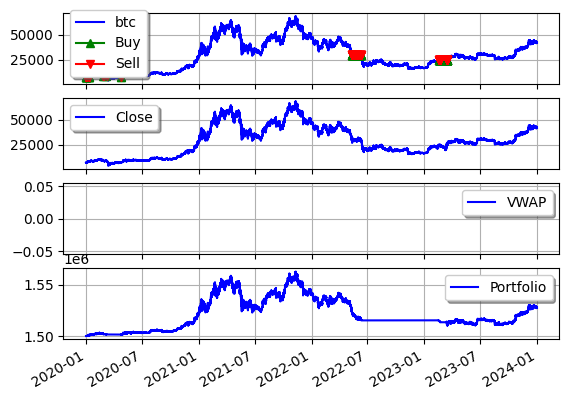

In [ ]:
def run_strategy():
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = VWAPStrategy(feed, "btc", broker)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    final_value = myStrategy.getResult()
    print(f'Final portfolio value: ${final_value:.2f}')
    plt.getOrCreateSubplot("VWAP").addDataSeries("VWAP", myStrategy.vwap_values)
    plt.plot()


run_strategy()

The **Z-Score Trading Strategy** can be compared to monitoring a thermometer during a weather forecast, where extreme temperature deviations signal action, similar to how extreme price deviations (Z-scores) indicate potential trading opportunities.

### Analogy:

- **Temperature Monitoring (Price Monitoring):** Imagine you are checking the temperature daily to decide if you should wear light clothes (buy) or heavy clothes (sell). In this case, the **temperature** represents the **price** of an asset, and you are keeping track of how much the temperature deviates from its usual range over time.

- **Normal Range (Mean and Standard Deviation):** Over a period of days, the temperature fluctuates, and you calculate an average (mean) temperature and how much it typically varies from that average (standard deviation). Similarly, in trading, the Z-score measures how far the latest price deviates from its average in standard deviation terms.

- **Unusually Cold Weather (Oversold Signal):** If the temperature drops far below the average, you notice an extreme deviation (Z-score is negative and below a threshold). This signals an **oversold condition**, like unusually cold weather. You might decide it’s a good time to **wear light clothes (buy the asset)** because conditions are likely to improve soon.

- **Unusually Hot Weather (Overbought Signal):** Conversely, if the temperature rises far above the average, the Z-score is positive and above a threshold. This indicates an **overbought condition**, like a heatwave. You might decide to **wear heavy clothes (sell the asset)**, expecting the weather to cool down.

In this analogy, just as you adjust your clothes based on extreme weather deviations from the norm, the **Z-Score Trading Strategy** involves adjusting your trading decisions based on how far the price deviates from its mean, signaling whether the market is overbought or oversold.

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter
import numpy as np

class ZScore:
    def __init__(self, period):
        self.period = period
        self.prices = []

    def add_price(self, price):
        self.prices.append(price)
        if len(self.prices) > self.period:
            self.prices.pop(0)

    def get_z_score(self):
        if len(self.prices) < self.period:
            return None
        mean = np.mean(self.prices)
        std_dev = np.std(self.prices)
        z_score = (self.prices[-1] - mean) / std_dev if std_dev != 0 else 0
        return z_score

class ZScoreTradingStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, zscore_threshold):
        super(ZScoreTradingStrategy, self).__init__(feed, broker)
        self.instrument = instrument
        self.zscore_threshold = zscore_threshold
        self.zscore_calculator = ZScore(period=30)
        self.position = None

    def onBars(self, bars):
        bar = bars[self.instrument]
        close = bar.getClose()
        self.zscore_calculator.add_price(close)
        z_score = self.zscore_calculator.get_z_score()

        if z_score is None:
            return
        if self.position is None and z_score < -self.zscore_threshold:
            self.position = self.enterLong(self.instrument, 1, True)
        elif self.position is not None and z_score > self.zscore_threshold:
            self.position.exitMarket()
            self.position = None

Final portfolio value: $1509724.14


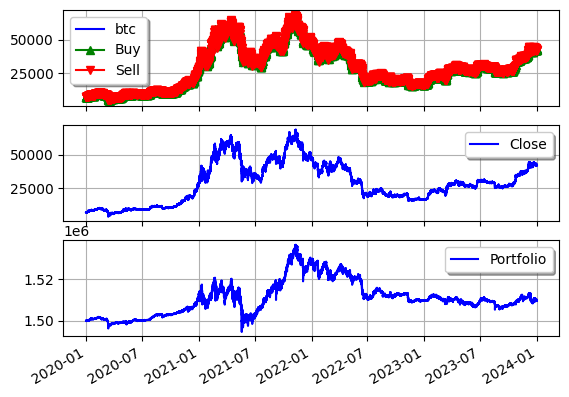

In [ ]:
def run_strategy(zscore_threshold):
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = ZScoreTradingStrategy(feed, "btc", broker, zscore_threshold)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()

    final_value = myStrategy.getResult()
    print(f'Final portfolio value: ${final_value:.2f}')

    plt.plot()

run_strategy(zscore_threshold=1)

The **Chaikin Oscillator Strategy** can be likened to monitoring the tide levels at a beach to decide whether to set sail or return to shore. In this analogy, the **oscillator** acts like a gauge that tracks the flow of water in and out of the harbor, helping determine the best time for action.

### Analogy:

- **Water Flow (Accumulation/Distribution):** Imagine you are by the ocean, and you observe the water levels rising (inflow) or falling (outflow). This represents how **money flows into or out of an asset** over time, measured by the Accumulation/Distribution (A/D) line in the strategy. When more water (or capital) flows in, the tide rises; when more flows out, it falls.

- **Short-Term Flow (Short Moving Average):** You check the water levels over a short period, much like the **short moving average (MA)** in the Chaikin Oscillator. This shows recent trends in how much water has flowed in or out, similar to recent price and volume activity.

- **Long-Term Flow (Long Moving Average):** You also look at the longer-term water levels over time, similar to the **long moving average**. This provides a broader perspective of the water flow (capital movement) across a more extended period.

- **Tide Shifts (Oscillator Crossing Zero):** When the **short-term flow rises above the long-term flow**, it’s like seeing the tide rise above average, signaling it's a good time to **set sail (buy the asset)** because the inflow of water (capital) indicates strong momentum. Conversely, when the **short-term flow falls below the long-term flow**, it's like the tide going out, signaling it might be time to **return to shore (sell the asset)**.

Just as you'd monitor the tides to decide when it's safe to sail, the **Chaikin Oscillator Strategy** monitors short and long-term money flows, looking for moments when momentum shifts (crosses zero) to guide buying or selling decisions.

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter
import numpy as np

class ChaikinOscillator:
    def __init__(self, short_window, long_window):
        self.short_window = short_window
        self.long_window = long_window
        self.ad_line = []
        self.chaikin_values = []

    def add_bar(self, close, high, low, volume):
        if high == low:
            ad_value = 0
        else:
            ad_value = volume * ((close - low) - (high - close)) / (high - low)
        self.ad_line.append(ad_value)
        if len(self.ad_line) >= self.long_window:
            short_ma = np.mean(self.ad_line[-self.short_window:])
            long_ma = np.mean(self.ad_line[-self.long_window:])
            chaikin_value = short_ma - long_ma
            self.chaikin_values.append(chaikin_value)

    def get_latest_chaikin(self):
        return self.chaikin_values[-1] if self.chaikin_values else None

class ChaikinOscillatorStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, short_window, long_window):
        super(ChaikinOscillatorStrategy, self).__init__(feed, broker)
        self.instrument = instrument
        self.co = ChaikinOscillator(short_window, long_window)
        self.position = None

    def onBars(self, bars):
        bar = bars[self.instrument]
        close = bar.getClose()
        high = bar.getHigh()
        low = bar.getLow()
        volume = bar.getVolume()
        self.co.add_bar(close, high, low, volume)
        chaikin_value = self.co.get_latest_chaikin()
        if self.position is None and chaikin_value is not None and chaikin_value > 0:
            self.position = self.enterLong(self.instrument, 1, True)
        elif self.position is not None and chaikin_value is not None and chaikin_value < 0:
            self.position.exitMarket()
            self.position = None

DEBUG:broker.backtesting:Not enough volume to fill btc market order [4143] for 1 share/s
2020-02-19 17:05:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [4143] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [33541] for 1 share/s
2021-02-11 07:50:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [33541] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [33541] for 1 share/s
2021-02-11 07:55:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [33541] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [33541] for 1 share/s
2021-02-11 08:00:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [33541] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [33541] for 1 share/s
2021-02-11 08:05:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [33541] for 1 

Final portfolio value: $1133996.33


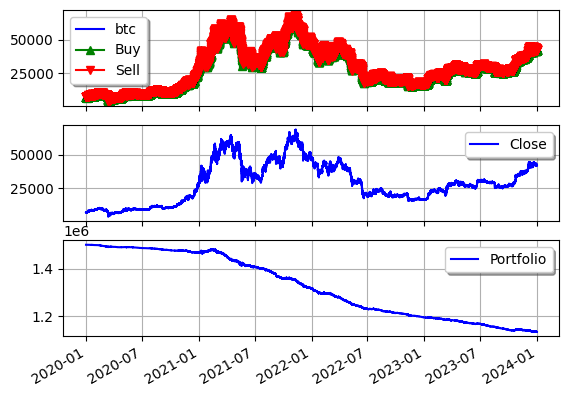

In [ ]:
def run_strategy(short_window=3, long_window=10):
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = ChaikinOscillatorStrategy(feed, "btc", broker, short_window, long_window)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    final_value = myStrategy.getResult()
    print(f'Final portfolio value: ${final_value:.2f}')
    plt.plot()


run_strategy(short_window=3, long_window=10)

The **Parabolic SAR Strategy** can be compared to following a bird as it rises or dives in the sky, where you make your decisions based on its highest and lowest points.

### Analogy:

- **The Bird's Flight (Price Movement):** Imagine you are watching a bird fly. Sometimes it flies higher (like prices rising in an uptrend), and sometimes it swoops lower (like prices falling in a downtrend). You track these highs and lows closely to decide when to act.

- **Extreme Point (Bird's Highest or Lowest Point):** The bird's highest point in the sky during an uptrend, or lowest point during a downtrend, is called the **Extreme Point (EP)** in the strategy. In an uptrend, you track the bird's highest flight (like the stock's high), while in a downtrend, you follow the lowest swoop (the stock's low).

- **Acceleration Factor (Speed of Bird’s Flight):** As the bird flies higher and faster (the stock rises), your **Acceleration Factor (AF)** increases, helping you keep up with the bird's movement. If the bird (price) slows down or reverses, the AF resets, just like how you'd adjust your speed to follow it closely.

- **Parabolic SAR (Following the Bird's Path):** The **Parabolic SAR** is like the path you follow beneath the bird. In an uptrend, you stay below it, ensuring you don't rise above the lowest point. In a downtrend, you stay above it, making sure you don’t fall below the highest point.

- **Trend Reversals (Bird Changes Direction):** When the bird suddenly swoops down after flying high (price reversal from uptrend), you react by changing your path to follow its descent. Similarly, when the bird rises after diving (price reversal from downtrend), you shift your path upwards. These moments of change are like the **trend reversals** the Parabolic SAR detects.

Just like you would closely track a bird's changing direction to decide where to go, the **Parabolic SAR Strategy** tracks price movements, ensuring you enter and exit trades at the right moments, based on changes in trend direction.

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter

class ParabolicSAR:
    def __init__(self, step=0.02, max_step=0.2):
        self.step = step
        self.max_step = max_step
        self.ep = None
        self.af = self.step
        self.sar = None
        self.is_uptrend = True

    def update(self, high, low):
        if self.sar is None:
            self.sar = low if self.is_uptrend else high
            self.ep = high if self.is_uptrend else low
        else:
            if self.is_uptrend:
                self.sar = self.sar + self.af * (self.ep - self.sar)
                self.sar = min(self.sar, low)
            else:
                self.sar = self.sar + self.af * (self.ep - self.sar)
                self.sar = max(self.sar, high)
        if self.is_uptrend:
            if high > self.ep:
                self.ep = high
                self.af = min(self.af + self.step, self.max_step)
            if low < self.sar:
                self.is_uptrend = False
                self.sar = self.ep
                self.ep = low
                self.af = self.step
        else:
            if low < self.ep:
                self.ep = low
                self.af = min(self.af + self.step, self.max_step)
            if high > self.sar:
                self.is_uptrend = True
                self.sar = self.ep
                self.ep = high
                self.af = self.step

        return self.sar

class ParabolicSARStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, step=0.02, max_step=0.2):
        super(ParabolicSARStrategy, self).__init__(feed, broker)
        self.instrument = instrument
        self.psar = ParabolicSAR(step, max_step)
        self.position = None

    def onBars(self, bars):
        bar = bars[self.instrument]
        high = bar.getHigh()
        low = bar.getLow()
        close = bar.getClose()

        sar = self.psar.update(high, low)

        if self.position is None and close > sar:
            self.position = self.enterLong(self.instrument, 1, True)
        elif self.position is not None and close < sar:
            self.position.exitMarket()
            self.position = None


INFO:strategy:Final portfolio value: $1535216.752024
2024-10-12 14:21:42,584 strategy [INFO] Final portfolio value: $1535216.752024


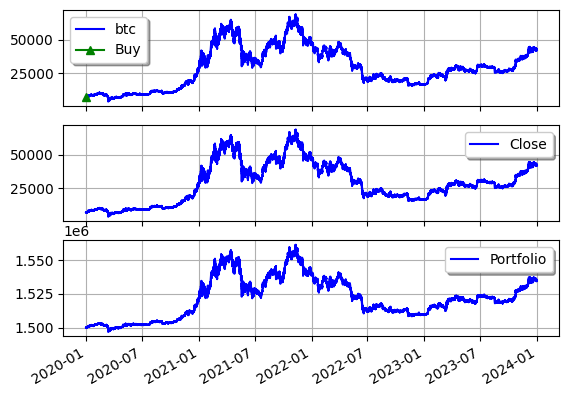

In [ ]:
def run_strategy(step=0.02, max_step=0.2):
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = ParabolicSARStrategy(feed, "btc", broker, step, max_step)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')

    plt.plot()

run_strategy(step=0.02, max_step=0.2)


The **Ichimoku Cloud Strategy** is like navigating through changing weather patterns in the sky to decide the safest path forward.

### Analogy:

- **Tenkan-sen and Kijun-sen (Short- and Long-Term Winds):** Imagine you're flying a plane and tracking two main winds. One wind is shorter term (**Tenkan-sen**), giving you quick updates on recent changes in wind speed and direction. The other wind is longer term (**Kijun-sen**), providing a broader view of how the wind has been behaving. You need both to determine whether the weather is improving or worsening.

- **Cloud Formation (Market Condition):** The area between **Senkou Span A** and **Senkou Span B** represents a cloud in the sky. If you're flying above the cloud, it means clear skies (an uptrend), but if you're flying below it, the weather is stormy (a downtrend). This helps you decide when to fly high (buy) or land (sell).

- **Chikou Span (Flight Tail):** The **Chikou Span** is like your plane's tail in the sky, showing where you were previously compared to where you are now. It gives you a perspective on whether you're advancing compared to your past position.

- **Flying Strategy (Trading Decisions):** If the short-term wind (**Tenkan-sen**) is stronger than the long-term wind (**Kijun-sen**), it signals clear weather ahead, so you take off and fly higher (buy). But if the long-term wind gets stronger than the short-term wind, it means turbulence is ahead, and you may want to land (sell) to avoid bad weather.

- **Cloud Shape (Future Outlook):** The cloud (formed by **Senkou Span A** and **Senkou Span B**) is projected forward, just like a weather forecast. If the cloud is wide, it indicates more uncertainty or potential storms, whereas a thin cloud suggests more stable conditions.

In this analogy, the **Ichimoku Cloud Strategy** helps traders navigate the financial "weather," deciding when to enter and exit trades by interpreting the winds (trend lines) and cloud patterns (support and resistance levels).

In [ ]:
import numpy as np
import pandas as pd
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter

class IchimokuCloud:
    def __init__(self, high_prices, low_prices, close_prices, period1=9, period2=26, period3=52):
        self.period1 = period1
        self.period2 = period2
        self.period3 = period3
        self.high_prices = high_prices
        self.low_prices = low_prices
        self.close_prices = close_prices
        self.tenkan_sen = None
        self.kijun_sen = None
        self.senkou_span_a = None
        self.senkou_span_b = None
        self.chikou_span = None

    def calculate(self):
        if len(self.high_prices) >= self.period1:
            self.tenkan_sen = (max(self.high_prices[-self.period1:]) + min(self.low_prices[-self.period1:])) / 2

        if len(self.high_prices) >= self.period2:
            self.kijun_sen = (max(self.high_prices[-self.period2:]) + min(self.low_prices[-self.period2:])) / 2

        if len(self.close_prices) >= self.period2:
            self.senkou_span_a = (self.tenkan_sen + self.kijun_sen) / 2
            self.senkou_span_b = (max(self.high_prices[-self.period3:]) + min(self.low_prices[-self.period3:])) / 2
            self.chikou_span = self.close_prices[-self.period2]

class IchimokuCloudStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker):
        super(IchimokuCloudStrategy, self).__init__(feed, broker)
        self.instrument = instrument
        self.ichimoku = IchimokuCloud([], [], [])
        self.position = None

    def onBars(self, bars):
        bar = bars[self.instrument]
        close = bar.getClose()
        high = bar.getHigh()
        low = bar.getLow()
        self.ichimoku.high_prices.append(high)
        self.ichimoku.low_prices.append(low)
        self.ichimoku.close_prices.append(close)
        self.ichimoku.calculate()

        if self.ichimoku.tenkan_sen is None or self.ichimoku.kijun_sen is None:
            return
        if self.position is None and self.ichimoku.tenkan_sen > self.ichimoku.kijun_sen:
            self.position = self.enterLong(self.instrument, 1, True)
        elif self.position is not None and self.ichimoku.tenkan_sen < self.ichimoku.kijun_sen:
            self.position.exitMarket()
            self.position = None


DEBUG:broker.backtesting:Not enough volume to fill btc market order [5903] for 1 share/s
2021-02-11 08:20:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [5903] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [5903] for 1 share/s
2021-02-11 08:25:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [5903] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [5903] for 1 share/s
2021-02-11 08:30:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [5903] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [5903] for 1 share/s
2021-02-11 08:35:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [5903] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [5903] for 1 share/s
2021-02-11 08:40:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [5903] for 1 share/s


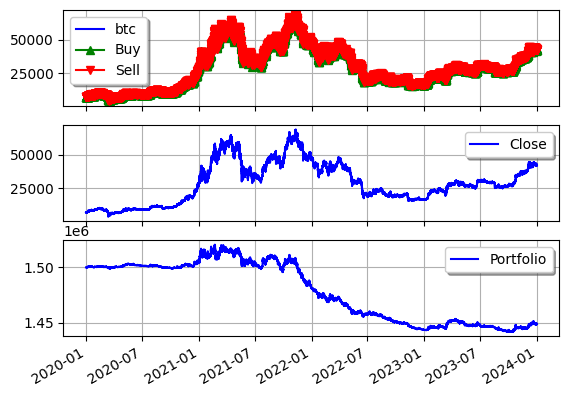

In [ ]:
def run_strategy():
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = IchimokuCloudStrategy(feed, "btc", broker)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()


run_strategy()


In [ ]:
import numpy as np
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter
class MeanReversionStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, moving_average_period):
        super(MeanReversionStrategy, self).__init__(feed, broker)
        self.instrument = instrument
        self.moving_average_period = moving_average_period
        self.moving_average = None
        self.position = None

    def onBars(self, bars):
        bar = bars[self.instrument]
        close = bar.getClose()
        if self.moving_average is None:
            self.moving_average = []

        self.moving_average.append(close)

        if len(self.moving_average) > self.moving_average_period:
            self.moving_average.pop(0)
        if len(self.moving_average) < self.moving_average_period:
            return

        current_ma = np.mean(self.moving_average)
        if self.position is None and close < current_ma:
            self.position = self.enterLong(self.instrument, 1, True)

        elif self.position is not None and close > current_ma:
            self.position.exitMarket()
            self.position = None


INFO:strategy:Final portfolio value: $1442833.112860009
2024-10-12 14:25:24,201 strategy [INFO] Final portfolio value: $1442833.112860009


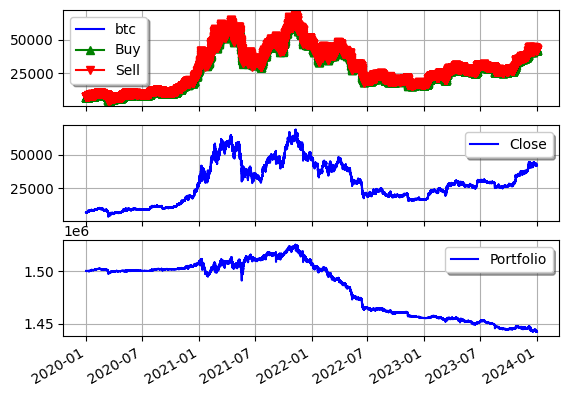

In [ ]:
def run_strategy(moving_average_period):
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = MeanReversionStrategy(feed, "btc", broker, moving_average_period)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()

run_strategy(moving_average_period=20)


The **Exponential Moving Average (EMA) Strategy** in your code follows the trend-following principle, using two EMAs with different periods (short-term and long-term) to generate buy and sell signals. Here's an analogy to help understand the strategy:

### Analogy:

Imagine you're walking along a path, and you have two friends: one is very quick (short-term EMA), and the other is slower and more steady (long-term EMA). You follow their lead to decide when to start or stop walking.

- **Short-term EMA (Quick Friend):** This friend is always fast to respond. They adjust quickly to changes in direction. In the context of stock prices, the short-term EMA reacts swiftly to recent price movements, giving you a more immediate sense of where the market is heading.

- **Long-term EMA (Steady Friend):** The long-term EMA represents your slower, more cautious friend. They take more time to adapt to changes, considering a broader view of the path before reacting.

- **Walking Decision (Trading Signals):**
  - When your quick friend (short EMA) walks ahead of your slow friend (long EMA), it's a sign to **start walking** (buy signal), as the path ahead seems clear and fast.
  - If your quick friend falls behind the slow friend, it's time to **stop walking** (sell signal), as they see the path becoming more uncertain.

In this analogy, the **EMA Strategy** relies on the fast-moving indicator (short EMA) to show when momentum is shifting, while the slow-moving indicator (long EMA) confirms the overall trend. When the short EMA crosses above the long EMA, it signals a potential upward trend (buy), and when it crosses below, it signals a downward trend (sell).

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter

class EMA:
    def __init__(self, period):
        self.period = period
        self.multiplier = 2 / (self.period + 1)
        self.ema_value = None

    def add_price(self, price):
        if self.ema_value is None:
            self.ema_value = price
        else:
            self.ema_value = ((price - self.ema_value) * self.multiplier) + self.ema_value

    def get_latest_ema(self):
        return self.ema_value

class EMAStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, short_window, long_window):
        super(EMAStrategy, self).__init__(feed, broker)
        self.instrument = instrument
        self.short_ema = EMA(short_window)
        self.long_ema = EMA(long_window)
        self.position = None

    def onBars(self, bars):
        bar = bars[self.instrument]
        close = bar.getClose()
        self.short_ema.add_price(close)
        self.long_ema.add_price(close)

        short_ema_value = self.short_ema.get_latest_ema()
        long_ema_value = self.long_ema.get_latest_ema()
        if short_ema_value is None or long_ema_value is None:
            return
        if self.position is None and short_ema_value > long_ema_value:
            self.position = self.enterLong(self.instrument, 1, True)
        elif self.position is not None and short_ema_value < long_ema_value:
            self.position.exitMarket()
            self.position = None


DEBUG:broker.backtesting:Not enough volume to fill btc market order [4637] for 1 share/s
2021-02-11 08:20:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [4637] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [4637] for 1 share/s
2021-02-11 08:25:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [4637] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [4637] for 1 share/s
2021-02-11 08:30:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [4637] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [4637] for 1 share/s
2021-02-11 08:35:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [4637] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [4637] for 1 share/s
2021-02-11 08:40:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [4637] for 1 share/s


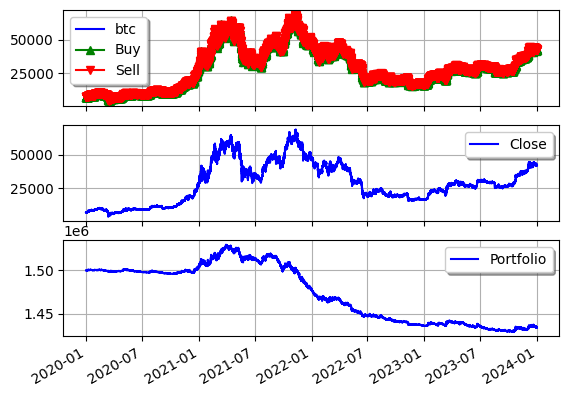

In [ ]:
def run_strategy(short_window, long_window):
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = EMAStrategy(feed, "btc", broker, short_window, long_window)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()

run_strategy(short_window=10, long_window=30)

The **Pivot Point Strategy** you've implemented utilizes pivot points, which are popular indicators in technical analysis to identify potential support and resistance levels in the price of an asset. Here's an analogy to help clarify how this strategy works:

### Analogy:

Imagine you're hiking up a mountain (the price of an asset) and using a map to find key reference points to guide your journey. These reference points are your **pivot points**, and they help you navigate the terrain effectively.

- **Pivot Point (The Summit):** The pivot point is like the mountain's peak, giving you a clear reference of where you are relative to your overall journey. It represents a potential balance point where the market sentiment may shift from bullish to bearish or vice versa.

- **Support Levels (Base Camp):** The support levels are like the base camps along the way. If the price (hiker) falls back to one of these points, it can rest and gather strength before attempting to climb higher again. These levels suggest that there’s enough support (interest from buyers) to prevent the price from falling further.

- **Resistance Levels (Ridges):** The resistance levels are like ridges you encounter on your hike. When you reach these heights, you might find it harder to continue climbing because there may be less interest from buyers (or more selling pressure). If the price breaks through a resistance level, it signifies strong momentum and the potential for continued upward movement.

- **Hiking Decision (Trading Signals):**
  - **Buy Signal (Crossing the Ridge):** When the price (hiker) climbs above the first resistance level, it's like successfully overcoming a ridge. This indicates bullish sentiment and can be a good point to enter a long position.
  - **Sell Signal (Falling Back to Base Camp):** If the price falls below the first support level, it’s akin to descending back to the base camp, suggesting a potential bearish reversal and prompting an exit from the position.

In this analogy, the **Pivot Point Strategy** acts as a guide for your trading decisions. By observing the price movements relative to the calculated pivot points, you can make informed choices about when to enter or exit trades, based on the potential for price reversals at these key levels.

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter

class PivotPoint:
    def __init__(self):
        self.pivot = None
        self.support1 = None
        self.support2 = None
        self.resistance1 = None
        self.resistance2 = None

    def calculate_pivot(self, high, low, close):
        self.pivot = (high + low + close) / 3
        self.support1 = (2 * self.pivot) - high
        self.support2 = self.pivot - (high - low)
        self.resistance1 = (2 * self.pivot) - low
        self.resistance2 = self.pivot + (high - low)

    def get_levels(self):
        return {
            "pivot": self.pivot,
            "support1": self.support1,
            "support2": self.support2,
            "resistance1": self.resistance1,
            "resistance2": self.resistance2,
        }

class PivotPointStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker):
        super(PivotPointStrategy, self).__init__(feed, broker)
        self.instrument = instrument
        self.pivot_point = PivotPoint()
        self.position = None
        self.previous_bar = None

    def onBars(self, bars):
        bar = bars[self.instrument]
        high = bar.getHigh()
        low = bar.getLow()
        close = bar.getClose()

        # Calculate pivot points using the previous bar
        if self.previous_bar is not None:
            prev_high = self.previous_bar.getHigh()
            prev_low = self.previous_bar.getLow()
            prev_close = self.previous_bar.getClose()
            self.pivot_point.calculate_pivot(prev_high, prev_low, prev_close)

        self.previous_bar = bar

        levels = self.pivot_point.get_levels()
        if levels["pivot"] is None:
            return

        if self.position is None and close > levels["resistance1"]:
            self.position = self.enterLong(self.instrument, 1, True)
        elif self.position is not None and close < levels["support1"]:
            self.position.exitMarket()
            self.position = None

INFO:strategy:Final portfolio value: $1088311.5303480085
2024-10-12 14:34:17,011 strategy [INFO] Final portfolio value: $1088311.5303480085


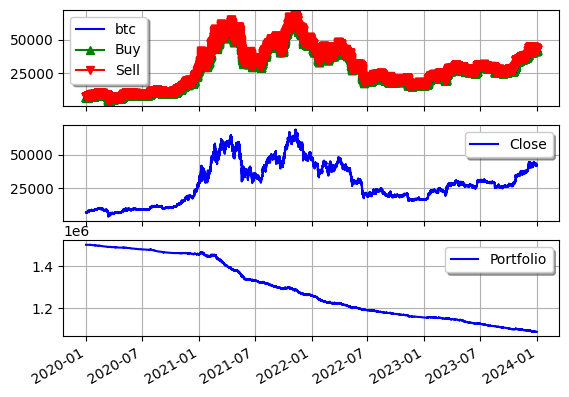

In [ ]:
def run_strategy():
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = PivotPointStrategy(feed, "btc", broker)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()


run_strategy()

The **Heikin-Ashi Strategy** you've implemented uses Heikin-Ashi candlesticks, a technique that transforms traditional candlestick charts to smooth out price action, making it easier to identify trends. Here’s an analogy to help clarify how this strategy works:

### Analogy:

Imagine you are a painter creating a landscape (the price movement of an asset). Instead of using traditional, distinct colors that may distract from the overall view, you decide to use a softer palette and blend the colors to create a smoother image. This technique is akin to the Heikin-Ashi approach.

- **Heikin-Ashi Candles (The Softened Landscape):** The Heikin-Ashi candlesticks are like your blended colors. They provide a more visually appealing and less chaotic representation of price action, allowing you to see trends more clearly without the noise that traditional candlesticks might present.

- **Heikin-Ashi Close (The Horizon):** The Heikin-Ashi close is like the horizon in your landscape. It indicates where the painting (price movement) is currently headed, based on the four main price components (open, high, low, close). When the horizon (close) rises above the foreground (open), it suggests the potential for upward momentum.

- **Heikin-Ashi Open (The Base Layer):** The Heikin-Ashi open serves as the base layer of your painting. It stabilizes the visual representation, providing a reference point for interpreting whether the market is bullish or bearish.

- **Trading Decisions (Brush Strokes):**
  - **Buy Signal (Rising Horizon):** When the Heikin-Ashi close rises above the Heikin-Ashi open, it’s like adding a bright color to your painting that signifies a beautiful sunrise. This indicates a bullish trend, prompting you to enter a long position.
  - **Sell Signal (Falling Horizon):** Conversely, when the Heikin-Ashi close falls below the Heikin-Ashi open, it’s like darkening the colors in your landscape, suggesting a potential sunset. This indicates a bearish trend and signals an exit from the position.

In this analogy, the **Heikin-Ashi Strategy** acts as your artistic guide. By observing the relationship between the Heikin-Ashi close and open, you can make informed trading decisions, entering or exiting trades based on the clarity of the trend, much like a painter who adjusts their brush strokes based on the evolving landscape of their artwork.

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter

class HeikinAshi:
    def __init__(self):
        self.ha_close = 0
        self.ha_open = 0
        self.ha_high = 0
        self.ha_low = 0

    def calculate(self, close, open_, high, low):
        if self.ha_close == 0 and self.ha_open == 0:
            self.ha_close = close
            self.ha_open = open_
        else:
            self.ha_close = (close + open_ + high + low) / 4
            self.ha_open = (self.ha_open + self.ha_close) / 2
        self.ha_high = max(high, self.ha_open, self.ha_close)
        self.ha_low = min(low, self.ha_open, self.ha_close)

        return self.ha_open, self.ha_high, self.ha_low, self.ha_close

class HeikinAshiStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker):
        super(HeikinAshiStrategy, self).__init__(feed, broker)
        self.instrument = instrument
        self.position = None
        self.ha = HeikinAshi()

    def onBars(self, bars):
        bar = bars[self.instrument]
        close = bar.getClose()
        open_ = bar.getOpen()
        high = bar.getHigh()
        low = bar.getLow()
        ha_open, ha_high, ha_low, ha_close = self.ha.calculate(close, open_, high, low)
        if self.position is None and ha_close > ha_open:
            self.position = self.enterLong(self.instrument, 1, True)
        elif self.position is not None and ha_close < ha_open:
            self.position.exitMarket()
            self.position = None

INFO:strategy:Final portfolio value: $1089040.8626239887
2024-10-12 14:35:29,321 strategy [INFO] Final portfolio value: $1089040.8626239887


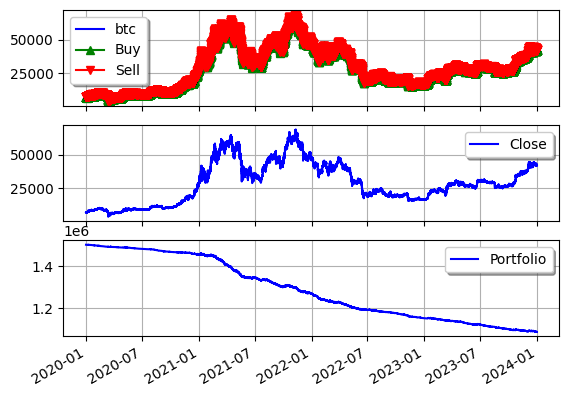

In [ ]:
def run_strategy():
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = HeikinAshiStrategy(feed, "btc", broker)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()


run_strategy()

The **Moving Average Envelopes Strategy** utilizes the concept of moving averages combined with bands to create a trading framework. Here’s an analogy to illustrate how this strategy functions:

### Analogy:

Imagine you are a sailor navigating a river (the financial market) with the help of a pair of floating buoys (the upper and lower bands). The moving average acts as the river’s current, guiding you along the path while the buoys mark the safe boundaries of your journey.

- **Moving Average (The River’s Current):** The moving average represents the average price of the asset over a specific period, much like the current of the river that influences your direction. It smooths out fluctuations, giving you a clearer view of the general trend of the market.

- **Envelopes (The Floating Buoys):** The upper and lower bands, set at a certain deviation from the moving average, are like the buoys floating on either side of the river. They define the safe navigation boundaries.
  - The **upper buoy** (upper band) indicates the threshold for overbought conditions—when the price rises too high, suggesting that it might be time to take action (enter a trade).
  - The **lower buoy** (lower band) indicates the threshold for oversold conditions—when the price drops too low, suggesting it may be time to exit a position or take a profit.

- **Trading Decisions (Navigating the River):**
  - **Entering a Trade (Crossing the Upper Buoy):** When the price (your boat) crosses above the upper buoy, it indicates that the asset is overbought, similar to sailing into choppy waters. You decide to enter a long position, anticipating a potential price correction.
  - **Exiting a Trade (Crossing the Lower Buoy):** Conversely, when the price drops below the lower buoy, it signals that the asset is oversold, akin to encountering shallow waters that could cause your boat to run aground. You exit the position, avoiding further losses.

In this analogy, the **Moving Average Envelopes Strategy** serves as your navigation system. By using the moving average as a guide and the envelopes as markers for overbought and oversold conditions, you can make informed trading decisions, adjusting your course as you respond to the river's changing conditions. This approach helps you navigate the complexities of the market more effectively, avoiding turbulent waters while seeking profitable opportunities.

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter

class MovingAverageEnvelopes:
    def __init__(self, period, deviation):
        self.period = period
        self.deviation = deviation
        self.prices = []
        self.sma = None

    def add_price(self, price):
        self.prices.append(price)
        if len(self.prices) > self.period:
            self.prices.pop(0)

        if len(self.prices) == self.period:
            self.sma = sum(self.prices) / self.period

    def get_upper_band(self):
        if self.sma is None:
            return None
        return self.sma * (1 + self.deviation)

    def get_lower_band(self):
        if self.sma is None:
            return None
        return self.sma * (1 - self.deviation)

class MovingAverageEnvelopesStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, ma_period, deviation):
        super(MovingAverageEnvelopesStrategy, self).__init__(feed, broker)
        self.instrument = instrument
        self.ma_envelopes = MovingAverageEnvelopes(ma_period, deviation)
        self.position = None

    def onBars(self, bars):
        bar = bars[self.instrument]
        close = bar.getClose()
        self.ma_envelopes.add_price(close)

        upper_band = self.ma_envelopes.get_upper_band()
        lower_band = self.ma_envelopes.get_lower_band()
        if upper_band is None or lower_band is None:
            return
        if self.position is None and close > upper_band:
            self.position = self.enterLong(self.instrument, 1, True)
        elif self.position is not None and close < lower_band:
            self.position.exitMarket()
            self.position = None

INFO:strategy:Final portfolio value: $1537074.3332390003
2024-10-12 14:41:11,162 strategy [INFO] Final portfolio value: $1537074.3332390003


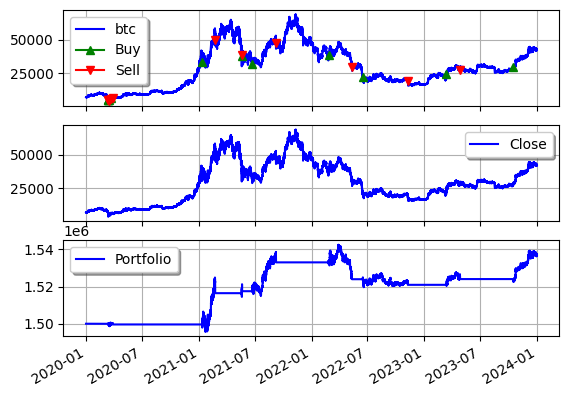

In [ ]:
def run_strategy(ma_period, deviation):
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = MovingAverageEnvelopesStrategy(feed, "btc", broker, ma_period, deviation)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')

    plt.plot()


run_strategy(ma_period=20, deviation=0.05)


**Gann Fan Strategy** :

### Analogy: Navigating a City with GPS

Imagine you are driving through a city using a GPS navigation system to reach a specific destination (your trading goal).

- **Base Price (Starting Point):** Your starting point on the map is like the base price in the Gann Fan Strategy. This is where you begin your journey and set your expectations for what the journey will entail.

- **Base Time (Travel Time):** The base time represents the timeframe you expect to reach your destination. It’s how long you plan to drive before checking your progress or making adjustments to your route.

- **Gann Angles (Routes):** The Gann angles—1x1, 2x1, and 1x2—represent different routes you can take to reach your destination:
  - The **1x1 route** is a direct and balanced path. For every mile you drive forward, you expect to gain a certain amount of value (or reach your target) in a consistent manner. This path is straightforward and represents a healthy market trend.
  - The **2x1 route** is more aggressive. It’s a shortcut that requires you to speed up, covering more distance in the same time frame. You aim for higher returns quickly, but it also comes with increased risk.
  - The **1x2 route** is more cautious. You take a longer route that allows you to enjoy the scenery, moving more slowly and steadily toward your goal. This route minimizes risk, focusing on a gradual increase in price over time.

- **Driving Strategy (Making Trades):**
  - **Entering a Trade (Choosing a Route):** When the current price (your car’s position on the GPS) exceeds the predicted path of the **1x1 route**, it’s like your GPS telling you that you are on the right track, and you decide to follow that path (enter a long position), anticipating a continued upward trend.
  - **Exiting a Trade (Deviating from the Path):** If the price drops below the **1x1 route**, your GPS recalculates and warns you that you are veering off course. This prompts you to rethink your route and decide to exit your position (like taking a different road) to minimize losses.

In this analogy, the **Gann Fan Strategy** is your GPS system guiding you through the financial landscape. By analyzing price movements against your predetermined routes (Gann angles), you can navigate the market effectively, making informed decisions about when to accelerate (enter trades) or slow down (exit trades). This method helps you stay on course towards your financial destination while adjusting your route based on real-time conditions.

In [10]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter
import math

class GannFanStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, base_price, base_time):
        super(GannFanStrategy, self).__init__(feed, broker)
        self.instrument = instrument
        self.position = None
        self.base_price = base_price
        self.base_time = base_time
        self.current_time = 0

    def onBars(self, bars):
        bar = bars[self.instrument]
        close = bar.getClose()
        self.current_time += 1
        gann_1x1 = self.calculate_gann_angle(1, 1)
        gann_2x1 = self.calculate_gann_angle(2, 1)
        gann_1x2 = self.calculate_gann_angle(1, 2)
        if self.position is None and close > gann_1x1:
            self.position = self.enterLong(self.instrument, 1, True)

        elif self.position is not None and close < gann_1x1:
            self.position.exitMarket()
            self.position = None

    def calculate_gann_angle(self, vertical_unit, horizontal_unit):
        price_move = vertical_unit * self.current_time
        time_move = horizontal_unit * self.current_time
        gann_angle = self.base_price + (price_move / time_move)
        return gann_angle


INFO:strategy:Final portfolio value: $1529300.3325220002
2024-10-13 03:31:35,931 strategy [INFO] Final portfolio value: $1529300.3325220002


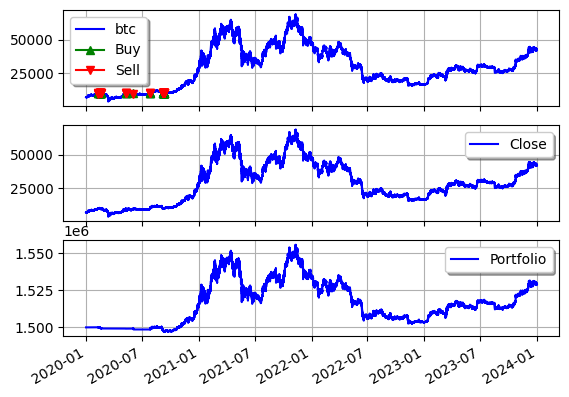

In [14]:
def run_strategy():
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    base_price = 10000
    base_time = 0
    myStrategy = GannFanStrategy(feed, "btc", broker, base_price, base_time)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())

    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')


    plt.plot()

run_strategy()


**Wolfe Wave Strategy** :

### Analogy: Building a Sandcastle at the Beach

Imagine you’re at the beach, building a magnificent sandcastle that requires careful planning and attention to detail. The **Wolfe Wave Strategy** can be likened to the process of constructing this sandcastle:

1. **Waves as Sandcastle Foundations:**
   - The five **waves** in the Wolfe Wave strategy represent the foundational shapes of your sandcastle. Each wave corresponds to a specific part of the structure you’re building. Just like a sandcastle has multiple layers or tiers, the Wolfe Wave strategy consists of various price movements that form a pattern.

2. **Detecting Waves (Shaping the Structure):**
   - As you start building, you notice the natural dips and peaks of the sand (the **bar prices**). You shape these into five distinct waves (or tiers) of your sandcastle. Each wave represents a **point of interest** (like a low point in price), which helps you visualize the overall design of your castle.
   - As you notice these waves forming, you carefully add more sand to maintain the structure, just as the strategy identifies price points that define the wave pattern.

3. **Completing the Structure (Identifying the Fifth Wave):**
   - Once you’ve formed the five waves, you stand back and assess the structure. When you have completed the foundation (all five waves), it’s time to add the finishing touches, just like how the strategy looks for a significant price action signal to enter a trade (like the price crossing above the last wave).

4. **Setting a Target (Envisioning the Final Look):**
   - With the completed waves in place, you visualize the final height and shape of your sandcastle. You determine how much taller you want to make it based on the distance between the first and fourth waves. This target height becomes your **target price** in the strategy.
   - The higher you want your castle to be (the target price), the more confident you become about the structure you’ve built.

5. **Making Decisions (Choosing the Right Time to Build):**
   - If the sandcastle starts to look impressive (the price goes above the fourth wave), you decide it’s time to celebrate your hard work by taking a photo of your creation (entering a long position).
   - However, if the tide comes in (the price drops below the third wave) or if your castle doesn’t look as grand as you hoped (the price reaches your target), you might decide to dismantle the structure (exit the trade).

### Conclusion

In this analogy, building the sandcastle is akin to following the **Wolfe Wave Strategy** in trading. Just as you construct a strong and visually appealing sandcastle by shaping the waves of sand, traders use the identified waves in the Wolfe Wave pattern to make informed decisions about entering and exiting positions in the market. The process requires patience, observation, and a clear vision of the final outcome.

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter
import numpy as np

class WolfeWaveStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker):
        super(WolfeWaveStrategy, self).__init__(feed, broker)
        self.instrument = instrument
        self.position = None
        self.waves = []  # Store the wave points
        self.target_price = None

    def onBars(self, bars):
        bar = bars[self.instrument]
        close = bar.getClose()
        self.detect_waves(bar)
        if len(self.waves) == 5:
            self.calculate_target()
            if self.position is None and close > self.waves[4]:
                self.position = self.enterLong(self.instrument, 1, True)
            elif self.position is not None and (close >= self.target_price or close < self.waves[3]):
                self.position.exitMarket()
                self.position = None

    def detect_waves(self, bar):
        if len(self.waves) < 5:
            self.waves.append(bar.getLow())
        elif len(self.waves) == 5:
            self.waves = []

    def calculate_target(self):
        wave_1 = self.waves[0]
        wave_4 = self.waves[3]

        self.target_price = wave_1 + (wave_4 - wave_1)

DEBUG:broker.backtesting:Not enough volume to fill btc market order [56178] for 1 share/s
2023-03-24 17:25:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [56178] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [56178] for 1 share/s
2023-03-24 17:30:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [56178] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [56178] for 1 share/s
2023-03-24 17:35:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [56178] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [56178] for 1 share/s
2023-03-24 17:40:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [56178] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [56178] for 1 share/s
2023-03-24 17:45:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [56178] for 

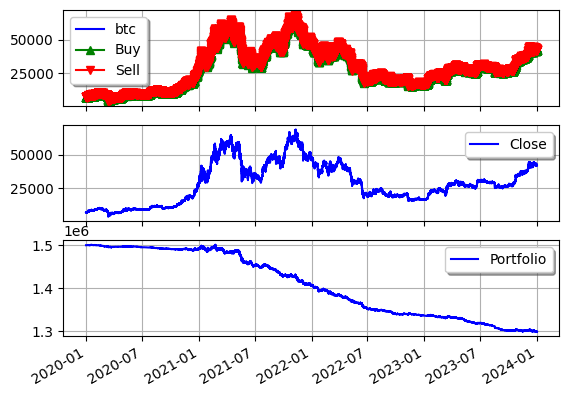

In [15]:
def run_strategy():
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = WolfeWaveStrategy(feed, "btc", broker)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())

    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')

    plt.plot()

run_strategy()


**ADL Strategy**
### Analogy: Gathering Firewood for a Campfire

Imagine you and your friends are out in the woods, preparing to build a cozy campfire for a night of storytelling. The process of gathering firewood and determining the right time to light the fire parallels the **ADL Strategy** in trading.

1. **Gathering Firewood (Monitoring Price and Volume):**
   - You start by collecting firewood. Each piece of wood represents a **price movement** (the **high**, **low**, **close**, and **volume**). As you gather wood, you pay attention to the quality of the logs you collect—whether they are dry and suitable for burning (strong price movements).
   - In trading, just like how you assess the quality of firewood, the strategy monitors price movements and trading volume to determine the strength of a price trend.

2. **Calculating Your Collection (Calculating the ADL):**
   - As you gather wood, you keep track of how much you’ve collected. You make note of whether the logs are thick or thin and whether they will burn well (this represents the **Accumulation/Distribution Line**). This tracking reflects how much "weight" your wood (or price movement) has.
   - You use a simple method: if you have more thicker logs, you know your collection is robust (accumulation). If you end up with mostly thin sticks, you realize your collection isn’t strong (distribution).

3. **Building the Fire (Making Trading Decisions):**
   - Once you have enough firewood, you consider the right moment to start your fire. You want to light the fire when your collection is solid, which is similar to waiting for confirmation of price movements and volume trends.
   - You notice two key signs:
     - When the logs from yesterday were fewer (the previous day's close was lower), but today’s collection is significantly stronger (today’s ADL has risen).
     - If you see that yesterday’s collection was strong (yesterday’s ADL was high), but today you have a poor collection (today’s ADL has dropped), you might decide to put out the fire (exit your position).

4. **Lighting the Fire (Entering and Exiting Trades):**
   - When you notice that your firewood collection is strong (when the close SMA and ADL SMA confirm a bullish signal), you strike a match and light your fire (enter a long position). This is when you feel confident that the fire will burn brightly.
   - If the next day you realize the wood isn’t dry anymore (the close SMA and ADL SMA start to decline), you extinguish the fire (exit your position) before it fizzles out, preventing you from wasting resources.

### Conclusion

In this analogy, gathering firewood for your campfire represents the process of analyzing market trends using the **ADL Strategy**. Just like how you assess the quality and quantity of your firewood to determine the best moment to start your fire, traders use price and volume data to make informed decisions about entering and exiting positions in the market. The key is to build a strong foundation (wood collection) to ensure a successful outcome (a warm campfire) for your trading journey.

In [ ]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade.technical import ma
from pyalgotrade.dataseries import SequenceDataSeries
from pyalgotrade import plotter

class ADLStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker):
        super(ADLStrategy, self).__init__(feed, broker)
        self.instrument = instrument
        self.position = None
        self.adl_values = SequenceDataSeries()
        self.close_sma = ma.SMA(feed[instrument].getCloseDataSeries(), 20)
        self.adl_sma = ma.SMA(self.adl_values, 20)

    def calculate_adl(self, bars):
        bar = bars[self.instrument]
        high = bar.getHigh()
        low = bar.getLow()
        close = bar.getClose()
        volume = bar.getVolume()
        money_flow_multiplier = ((close - low) - (high - close)) / (high - low) if (high - low) != 0 else 0
        money_flow_volume = money_flow_multiplier * volume
        prev_adl = self.adl_values[-1] if len(self.adl_values) > 0 else 0
        current_adl = prev_adl + money_flow_volume
        self.adl_values.append(current_adl)

    def onBars(self, bars):
        self.calculate_adl(bars)
        if len(self.adl_values) < 20:
            return
        close = bars[self.instrument].getClose()
        if self.close_sma[-1] is None or self.close_sma[-2] is None or self.adl_sma[-1] is None or self.adl_sma[-2] is None:
            return
        if self.position is None and self.close_sma[-1] < self.close_sma[-2] and self.adl_sma[-1] > self.adl_sma[-2]:
            self.position = self.enterLong(self.instrument, 1, True)
        elif self.position is not None and self.close_sma[-1] > self.close_sma[-2] and self.adl_sma[-1] < self.adl_sma[-2]:
            self.position.exitMarket()
            self.position = None


DEBUG:broker.backtesting:Not enough volume to fill btc market order [2722] for 1 share/s
2021-02-11 09:00:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [2722] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [2722] for 1 share/s
2021-02-11 09:05:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [2722] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [2722] for 1 share/s
2021-02-11 09:10:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [2722] for 1 share/s
INFO:strategy:Final portfolio value: $1457790.3933899929
2024-10-13 03:52:57,957 strategy [INFO] Final portfolio value: $1457790.3933899929


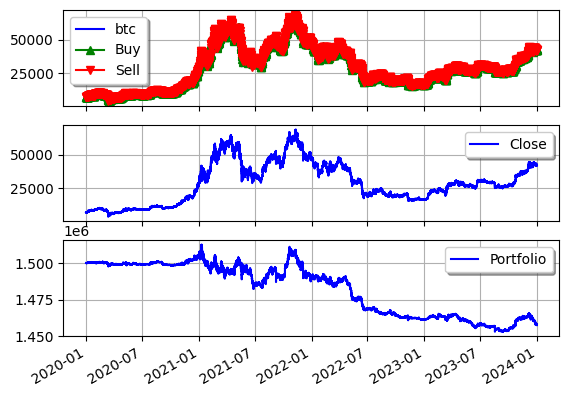

In [18]:

def run_strategy():
    feed = csvfeed.GenericBarFeed(frequency=60)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = ADLStrategy(feed, "btc", broker)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()

run_strategy()
